In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from functools import partial
from einops import rearrange, repeat
import gymnasium as gym
import gym as gym_old
from tqdm.auto import tqdm
import procgen
import cv2
import os
# from ppo import *

from IPython.display import clear_output

In [3]:
import env_utils
import models
import ppo_rnd

In [4]:
import train
import pretrain
import bc

In [132]:
%%time
np.random.seed(1)
env = env_utils.make_env(64, async_=False, reward_fn='eps')
obs, info = env.reset()
for i in tqdm(range(100)):
    obs, r, term, trunc, info = env.step(env.action_space.sample())
    # print(r)
    # print('-----------')
    # print(r.item())
    # plt.subplot(121)
    # plt.imshow(obs[0, -1])
    # plt.subplot(122)
    # plt.imshow(env.envs[0].mask)
    # plt.show()

 89%|████████▉ | 89/100 [00:03<00:00, 26.54it/s]


KeyboardInterrupt: 

In [148]:
env = env_utils.make_env(1)
agent = models.Agent(env)
# agent.load_state_dict(torch.load(f"data/distill_miner_{32:05d}_ext/agent.pt"))
env = eval_zero_shot(agent, n_envs, 3000, device='cuda:1')
rets_random = [np.array(e.past_returns[1:]) for e in env.envs]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:57<00:00, 16.91it/s]


In [104]:
def eval_zero_shot(agent, n_envs=128, n_steps=1100, device=None):
    np.random.seed(0)
    torch.manual_seed(0)

    level_id = [10000+int(i) for i in np.arange(n_envs)]
    env = env_utils.make_env(n_envs, level_id=level_id)
    
    agent = agent.to(device)
    obs, _ = env.reset() # or just step randomly first time
    for step in tqdm(range(n_steps)):
        obs = torch.from_numpy(obs)
        with torch.no_grad():
            action, _, _, _, _ = agent.get_action_and_value(obs.to(device))
        obs, reward, term, trunc, info = env.step(action.tolist())
        
    return env

n_envs = 256

env = env_utils.make_env(1)
agent = models.Agent(env)
agent.load_state_dict(torch.load(f"data/distill_miner_{32:05d}_ext/agent.pt"))
env = eval_zero_shot(agent, n_envs, 3000, device='cuda:1')
rets_ext = [np.array(e.past_returns[1:]) for e in env.envs]

env = env_utils.make_env(1)
agent = models.Agent(env)
agent.load_state_dict(torch.load(f"data/distill_miner_{32:05d}_int/agent.pt"))
env = eval_zero_shot(agent, n_envs, 3000, device='cuda:1')
rets_int = [np.array(e.past_returns[1:]) for e in env.envs]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:54<00:00, 17.24it/s]


In [150]:
mean_rets_ext = np.array([i.mean() for i in rets_ext])
mean_rets_int = np.array([i.mean() for i in rets_int])
mean_rets_random = np.array([i.mean() for i in rets_random])
diff = mean_rets_ext-mean_rets_int

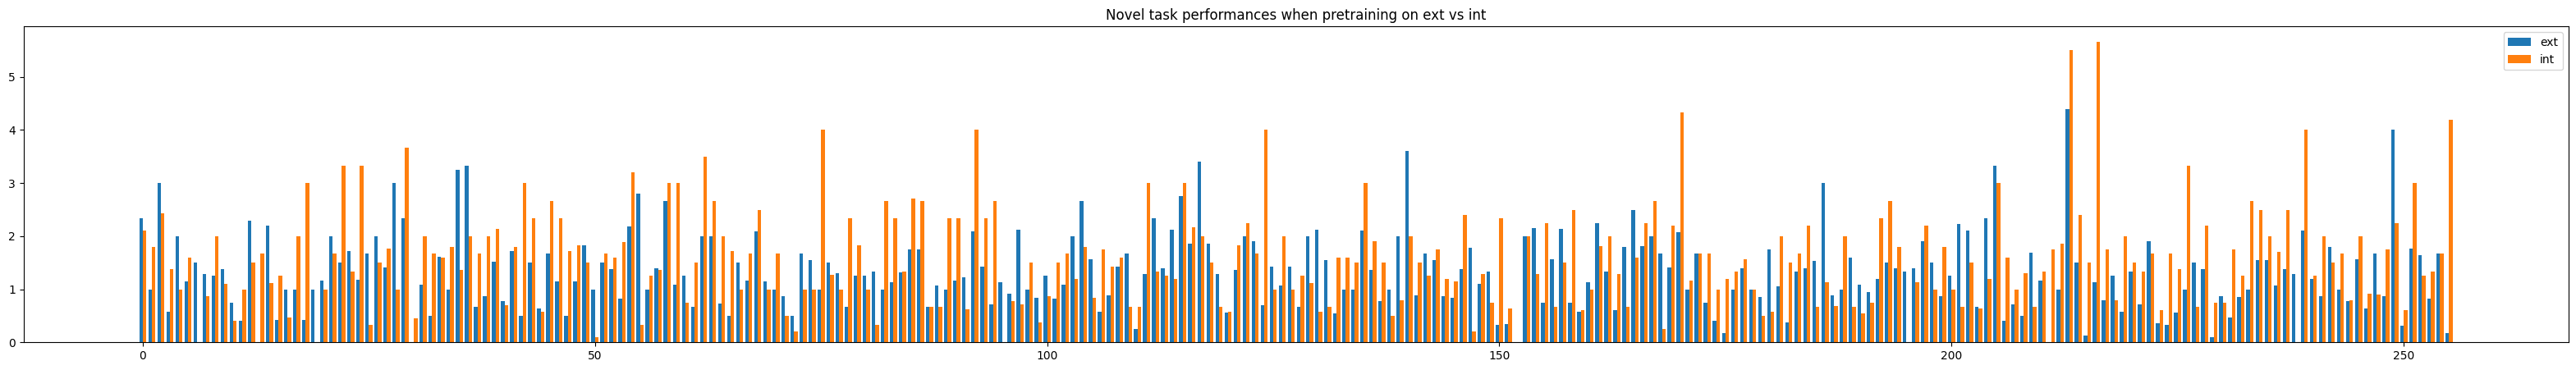

In [130]:
plt.figure(figsize=(40, 5))
plt.title('Novel task performances when pretraining on ext vs int')
x = np.arange(len(rets_ext))
plt.bar(x-0.2, mean_rets_ext, .4, label='ext')
plt.bar(x+0.2, mean_rets_int, .4, label='int')
plt.legend()
plt.show()

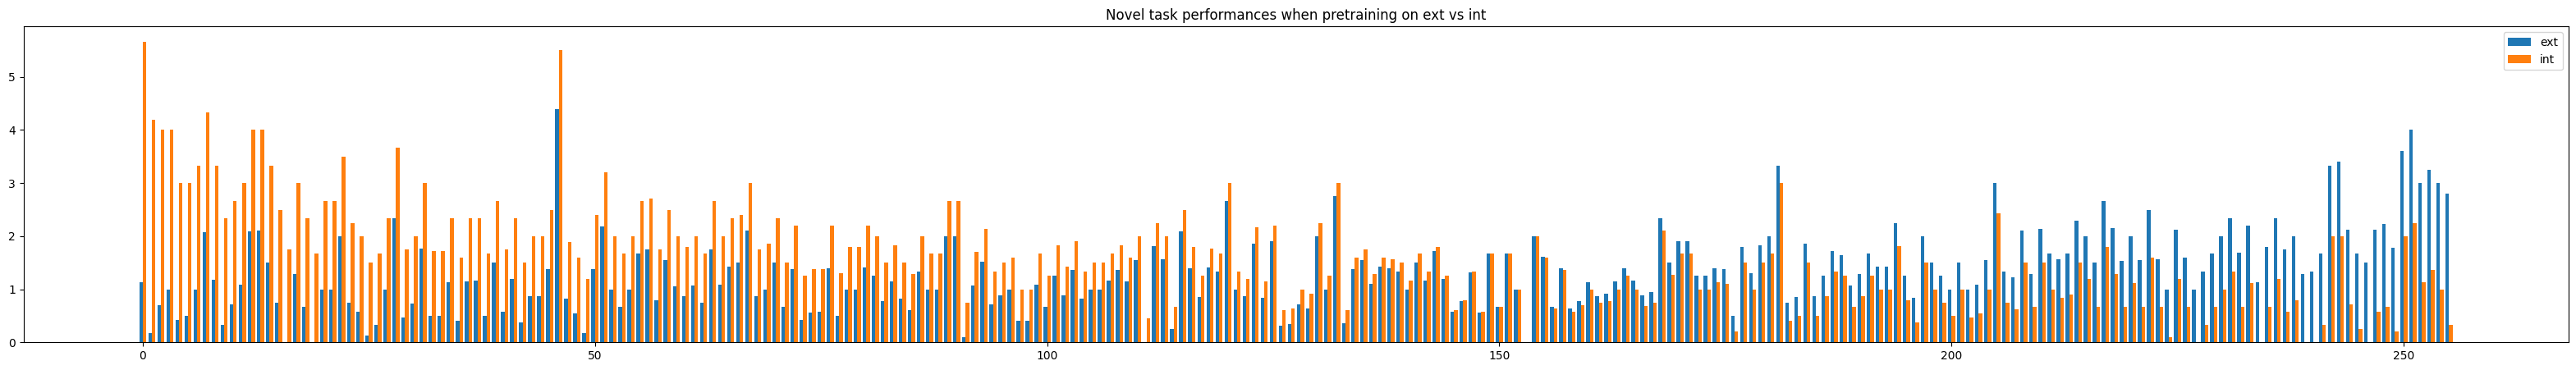

In [131]:
plt.figure(figsize=(40, 5))
plt.title('Novel task performances when pretraining on ext vs int')
x = np.arange(len(rets_ext))
plt.bar(x-0.2, mean_rets_ext[np.argsort(diff)], .4, label='ext')
plt.bar(x+0.2, mean_rets_int[np.argsort(diff)], .4, label='int')
plt.legend()
plt.show()

In [159]:
print(f'Average return on new task with ext pretraining: {mean_rets_ext.mean()}')
print(f'std error: {mean_rets_ext.std()}')
print(f'std error: {mean_rets_ext.std()/np.sqrt(256)}')
print(f'Average return on new task with int pretraining: {mean_rets_int.mean()}')
print(f'std error: {mean_rets_int.std()}')
print(f'std error: {mean_rets_int.std()/np.sqrt(256)}')
print(f'Average return on new task with random agent: {mean_rets_random.mean()}')

print(f'Intrinsic better for pretraining in {(diff<0).sum()/len(diff)*100: 2.02f}% of novel tasks')

Average return on new task with ext pretraining: 1.3326696665087265
std error: 0.7128807027969379
std error: 0.04455504392480862
Average return on new task with int pretraining: 1.5931611519990425
std error: 0.9196838913920129
std error: 0.057480243212000806
Average return on new task with random agent: 0.8072232631109221
Intrinsic better for pretraining in  58.20% of novel tasks


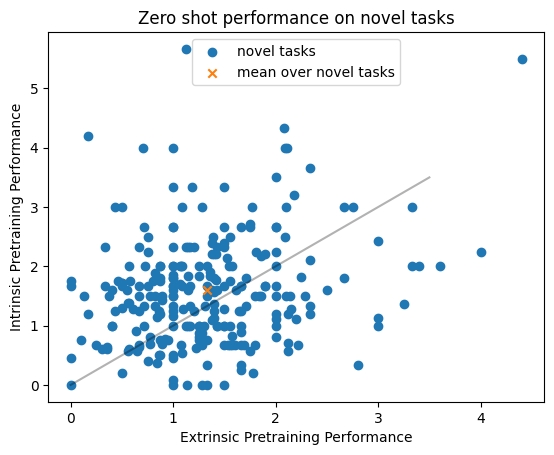

In [134]:
plt.title('Zero shot performance on novel tasks')
plt.scatter(mean_rets_ext, mean_rets_int, label='novel tasks')
plt.scatter([mean_rets_ext.mean()], [mean_rets_int.mean()], marker='x', label='mean over novel tasks')
plt.plot([0,3.5],[0,3.5], c=[0,0,0, .3])
plt.xlabel('Extrinsic Pretraining Performance')
plt.ylabel('Intrinsic Pretraining Performance')
plt.legend()
plt.show()

In [146]:
def robust_mean(x):
    mask = np.abs(x-x.mean())/x.std()<2.
    x = x[mask]
    return x.mean()

In [147]:
print(mean_rets_ext.mean(), mean_rets_int.mean())
print(mean_rets_ext.mean()-mean_rets_int.mean())
print(robust_mean(mean_rets_ext), robust_mean(mean_rets_int))
print(robust_mean(mean_rets_ext)-robust_mean(mean_rets_int))

1.3326696665087265 1.5931611519990425
-0.260491485490316
1.2410072161614993 1.4836690579068625
-0.2426618417453632


In [ ]:
load_state_dict

In [56]:
def eval_agent(agent, level, n_envs=10, device=None):
    env = env_utils.make_env(n_envs, level_id=level)
    agent = agent.to(device)

    obs, _ = env.reset() # or just step randomly first time
    for step in tqdm(range(1100)):
        obs = torch.from_numpy(obs)
        with torch.no_grad():
            action, _, _, _, _ = agent.get_action_and_value(obs.to(device))
        obs, reward, term, trunc, info = env.step(action.tolist())
        
    rets = [e.past_returns[-1] for e in env.envs]
    print(rets)

In [57]:
args = pretrain.parser.parse_args('--pretrain-levels 1 --pretrain-obj ext --device cuda:2 --ds_size 1e9 --n_steps 100'.split())
print(args)
kwargs = pretrain.main(args)

Namespace(device='cuda:2', track=False, seed=0, env='miner', pretrain_levels=1, pretrain_obj='ext', ds_size=1000000000.0, lr=0.001, coef_entropy=0.01, n_dataset=1000000.0, batch_size=1024, n_steps=100)
Namespace(device='cuda:2', track=False, seed=0, env='miner', pretrain_levels=1, pretrain_obj='ext', ds_size=1000000000.0, lr=0.001, coef_entropy=0.01, n_dataset=1000000.0, batch_size=1024, n_steps=100)
distill_miner_00001_ext
data/distill_miner_00001_ext
n=20, n_steps=20000, len(files_flat)=1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:41<00:00, 41.75s/it]


Dataset size: torch.Size([1, 20000, 1, 4, 64, 64, 3]), torch.Size([1, 20000, 1]), torch.uint8
Dataset size: torch.Size([20000, 4, 64, 64, 3]), torch.Size([20000]), torch.uint8
Agent # parameters: 000000472615


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.87it/s, distill/loss_bc=0.712, distill/loss_entropy=0.698]

done


In [58]:
agent = kwargs['agent']

In [59]:
eval_agent(agent, 0, 10, 'cuda:1')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:05<00:00, 191.71it/s]

[2.0, 1.0, 5.0, 3.0, 4.0, 2.0, 0.0, 2.0, 0.0, 3.0]


In [38]:
        
device = 'cuda:1'
agent = models.Agent(env)
agent.load_state_dict(torch.load(f"data/miner_{21:05d}_{'ext'}/agent_{240:05d}.pt"))

eval_agent(agent, 21, device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:02<00:00, 369.09it/s]

[10.0, 10.0, 9.0, 10.0, 8.0]


In [539]:
o = x[0, :, 0]
o.shape

torch.Size([4000, 4, 64, 64, 3])

In [541]:
for i, (o1, o2) in enumerate(zip(o[:-1], o[1:])):
    if not (o1[1:]==o2[:-1]).all().item():
        print(i)

999
1015
2015
3015
3025


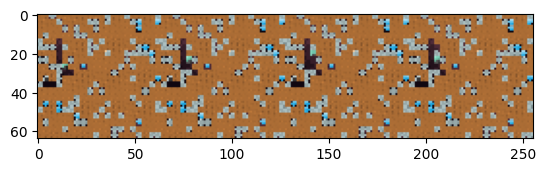

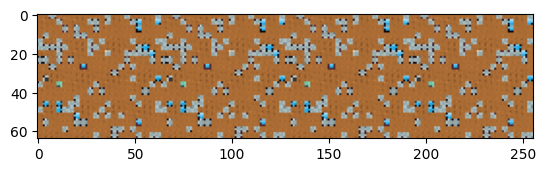

False
term
bruh wtf


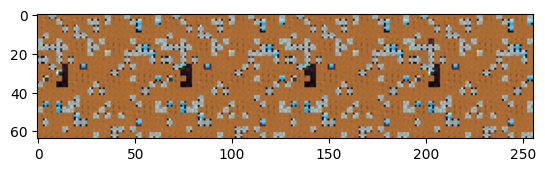

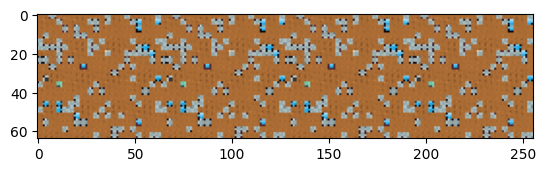

False
term
bruh wtf


In [538]:
np.random.seed(0)

env = env_utils.make_env(1)

obs, _ = env.reset()
obs = obs[0]
for i in range(50):
    nobs, _, term, trunc, _ = env.step(env.action_space.sample())
    nobs = nobs[0]
    
    if term.item():
        plt.imshow(rearrange(obs, 'b h w c -> h (b w) c'))
        plt.show()
        plt.imshow(rearrange(nobs, 'b h w c -> h (b w) c'))
        plt.show()
        print((obs[1:]==nobs[:-1]).all().item())
    
    if term.item():
        print('term')
    if not (obs[1:]==nobs[:-1]).all().item():
        print('bruh wtf')
    obs = nobs

In [5]:
parser = main.parse_args()

In [7]:
args = parser.parse_args('')

In [49]:
env = miner.make_env(10, level_id=0)
env.reset()
for i in range(1100):
    env.step(env.action_space.sample())
    

In [40]:
video = env.envs[0].past_traj_obs
video.shape

(113, 64, 64, 3)

In [48]:
wandb.log(dict(vid1=wandb.Video(rearrange(video, 't h w c->t c h w'), fps=15)))

In [5]:
def plot_rewards(envs):
    minlen = min([len(e.past_returns) for e in envs.envs])
    past_returns = np.array([e.past_returns[-minlen:] for e in envs.envs])
    mean = past_returns.mean(axis=0)
    min_ = past_returns.min(axis=0)
    max_ = past_returns.max(axis=0)
    stderr = past_returns.std(axis=0)/np.sqrt(past_returns.shape[0])
    x = np.arange(len(mean))
    plt.plot(x, mean, c='b')
    plt.plot(x, min_, c='r')
    plt.plot(x, max_, c='g')
    plt.fill_between(x, mean-stderr, mean+stderr, color=[0, 0, 1, .2])

In [7]:
env = miner.make_env(64)

r = []
r_means, r_stds = [], []
def callback(update, rewards, **kwargs):
    if update%1==0:
        e = env.envs[0]
        r_means.append(np.mean([e.past_returns[-1] for e in env.envs]))
        r_stds.append(np.std([e.past_returns[-1] for e in env.envs]))
        r.append(rewards.mean().item())
        clear_output(wait=True)
        o = kwargs['b_obs'][:, -1].cpu().numpy()
        o = o.std(axis=0).mean(axis=-1)
        heatmap = (o/o.max()*255).astype(np.uint8)
        
        plt.subplot(221)
        plt.imshow(e.first_obs)
        plt.subplot(222)
        plt.imshow(o)
        plt.show()
        
        plt.figure(figsize=(10, 3))
        plt.plot(r_means, color='b')
        mean, std = np.array(r_means), np.array(r_stds)
        plt.fill_between(range(len(mean)), mean-std, mean+std, color=[0,0, 1.,.2])
        plt.show()
    
agent = models.Agent(env)
rnd = models.RNDModel(env, (64, 64, 3))
n_params = np.sum([p.numel() for p in agent.parameters()])
print(f'Agent # parameters: {n_params:012d}')
n_params = np.sum([p.numel() for p in rnd.parameters()])
print(f'RND   # parameters: {n_params:012d}')

parser = ppo_rnd.parse_args()
args = parser.parse_args('--total-timesteps 2000000 --ext-coef 0.0 --int-coef 1.0 --num-minibatches 50 --ent-coef 0.0'.split())
args.total_timesteps
ppo_rnd.run(agent, rnd, env, args, callback_fn=callback)

Agent # parameters: 000000472615
RND   # parameters: 000001726784
Using device cpu
Start to initialize observation normalization parameter.....


100%|██████████| 10/10 [00:00<00:00, 33.44it/s]


End to initialize...


  0%|          | 0/122 [00:29<?, ?it/s]


KeyboardInterrupt: 

In [108]:
device = 'cuda:0'
env = miner.make_env(64)
agent = models.Agent(env)
agent = agent.to(device)

In [120]:
def do_rollout(agent, env, timesteps=256, device=None):
    agent = agent.to(device)
    obs, info = env.reset()
    for i in tqdm(range(timesteps)):
        with torch.no_grad():
            obs = torch.from_numpy(obs).to(device)
            action, _, _, _, _ = agent.get_action_and_value(obs)
            obs, _, _, _, _ = env.step(action.tolist())
        

In [80]:
# it takes around 3.04 seconds to generate a batch of 64x256 transitions

3.04

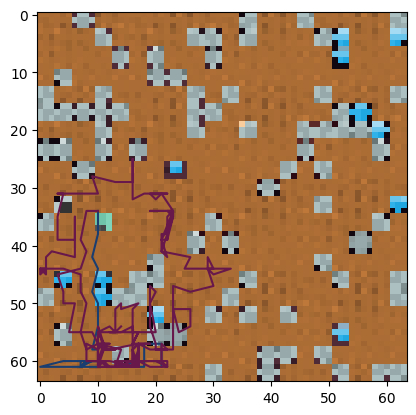

In [109]:
def calc_traj(traj_obs):
    a = traj_obs
    c = np.array([111, 196, 169])
    
    y, x = [], []
    a = np.abs(a-c).mean(axis=-1)
    for ai in a:
        yi, xi = np.unravel_index(ai.argmin(), ai.shape)
        y.append(yi)
        x.append(xi)
    y, x = np.array(y), np.array(x)
    x += np.random.randint(-1, 1, x.shape)
    y += np.random.randint(-1, 1, y.shape)
    c = np.random.rand(3)*.5

    plt.plot(x, y, c=c)

plt.imshow(env.envs[1].first_obs)

for e in env.envs[:2]:
    calc_traj(e.past_traj_obs)

In [1]:
first_obs = env.envs[0].first_obs.copy()
calc_traj_cov = lambda o:(o.std(axis=0).mean(axis=-1)>0).sum()/first_obs.mean(axis=-1).size
traj_cov = np.array([calc_traj_cov(e.past_traj_obs) for e in env.envs])
full_cov = calc_traj_cov(np.concatenate([e.past_traj_obs for e in env.envs]))

NameError: name 'env' is not defined

In [145]:
traj_cov.mean(), full_cov

(0.07220458984375, 0.68701171875)

In [11]:
env = miner.make_env(10)
env.reset()
for i in tqdm(range(1200)):
    env.step(env.action_space.sample())

100%|██████████| 1200/1200 [00:02<00:00, 597.21it/s]


In [13]:
env.envs[0].past_traj_obs.shape

(113, 64, 64, 3)

In [89]:
e = miner.make_env(1)
e.reset()
for i in tqdm(range(2000)):
    e.step([np.random.choice([3,4])])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3562.52it/s]


In [90]:
o = e.envs[0].past_traj_obs
o.shape

(1001, 64, 64, 3)

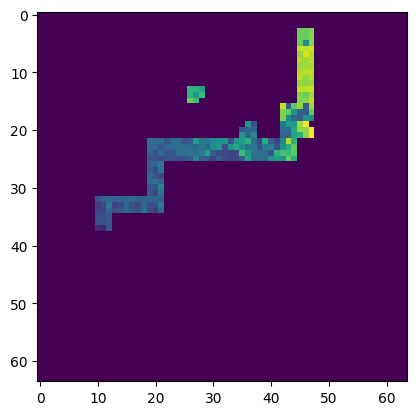

In [91]:
a = np.array([ei.past_traj_obs.std(axis=0).mean(axis=-1) for ei in e.envs])[[0]].max(axis=0)
plt.imshow(a)

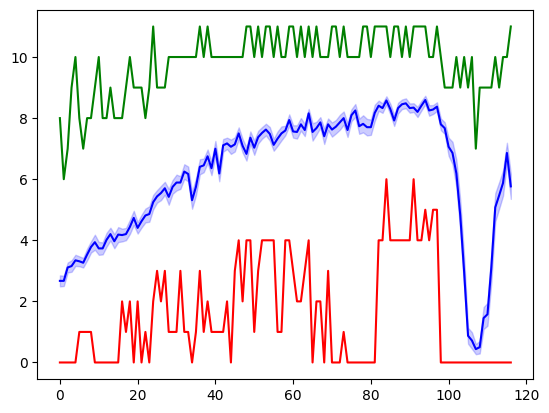

In [168]:
plot_rewards(env)

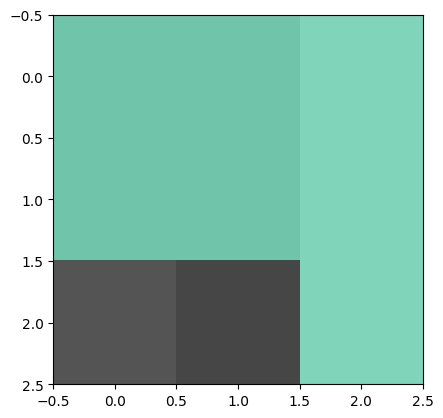

In [63]:
plt.imshow(env.envs[0].first_obs[35: 38, 10:13])

In [66]:
env.envs[0].first_obs[35: 38, 10:13][1, 1]

array([111, 196, 169], dtype=uint8)

In [169]:
np.argmax([np.max(e.past_returns) for e in env.envs])

3

In [170]:
np.argmax(env.envs[3].past_returns)

60

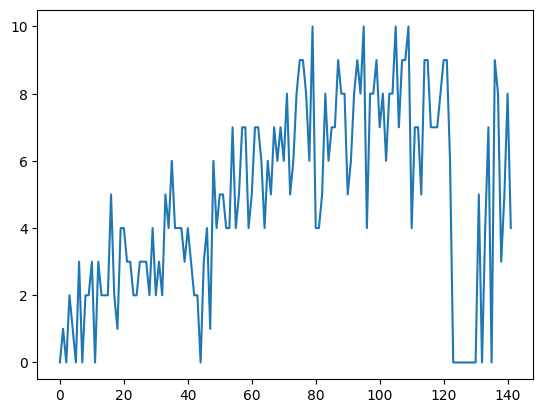

In [176]:
plt.plot(env.envs[0].past_returns)

In [177]:
env.envs[0].past_returns[125]

0.0

In [180]:
env.envs[0].past_returns[-1], env.envs[0].past_lengths[-1]

(4.0, 134)

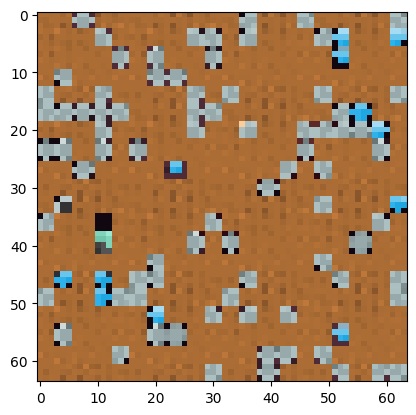

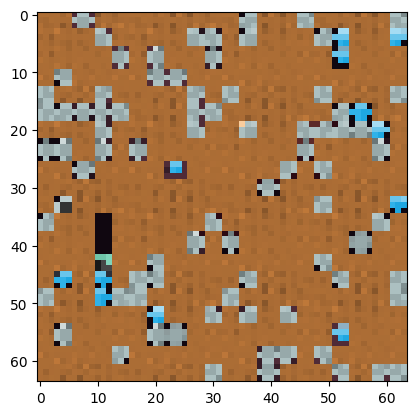

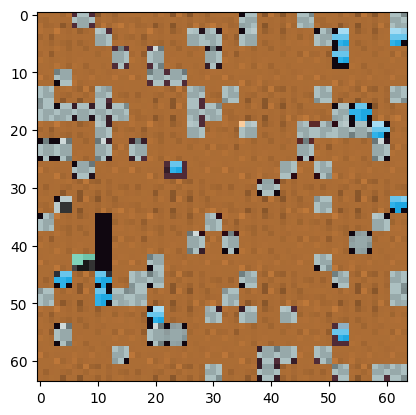

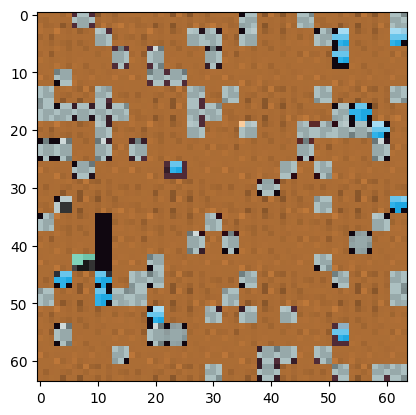

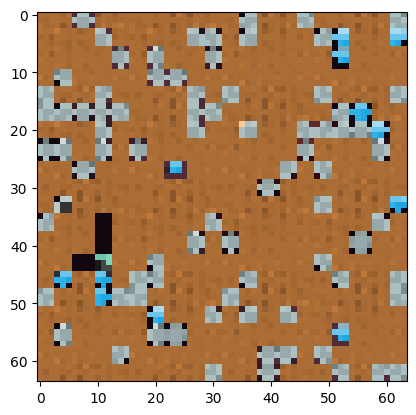

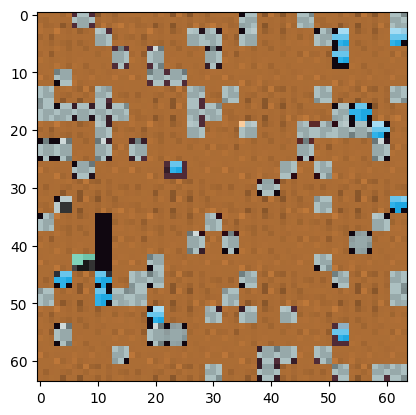

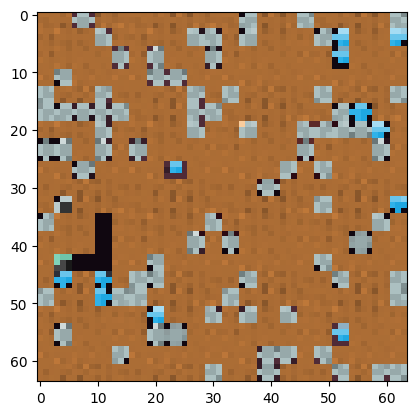

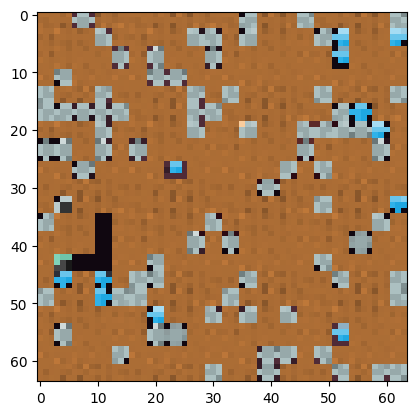

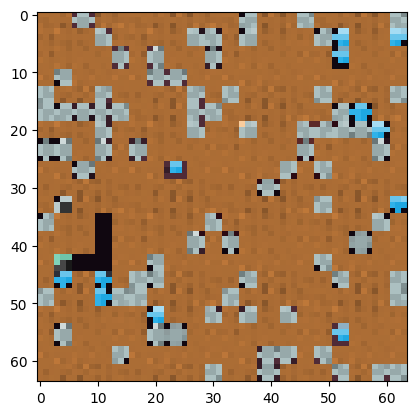

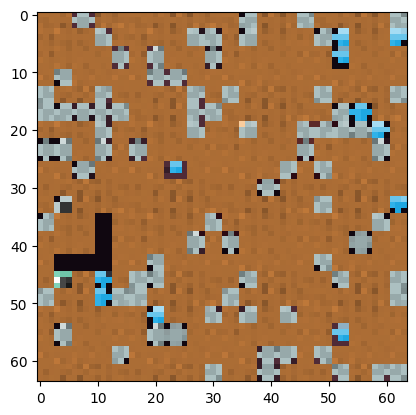

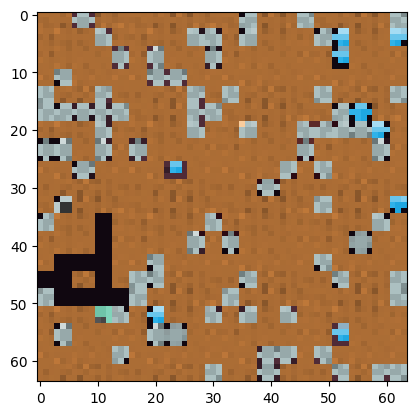

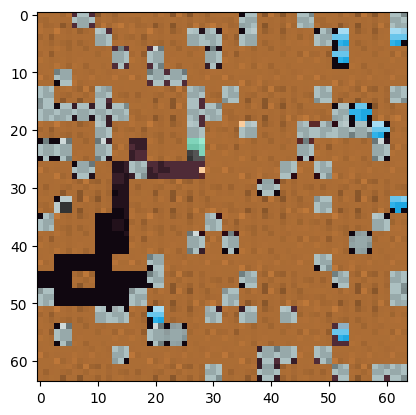

In [181]:
e = make_single_env()
obs, _ = e.reset()
for i, action in enumerate(env.envs[0].past_actions[-1]):
    obs, _, _, _, _ = e.step(action)
    if i<10 or i%50==0:
        plt.imshow(obs[-1])
        plt.show()

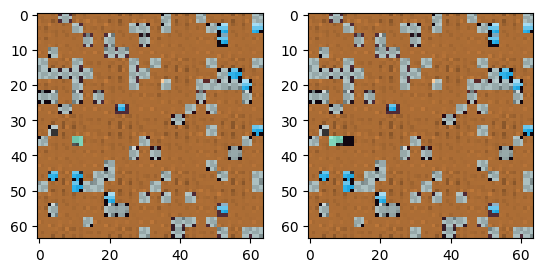

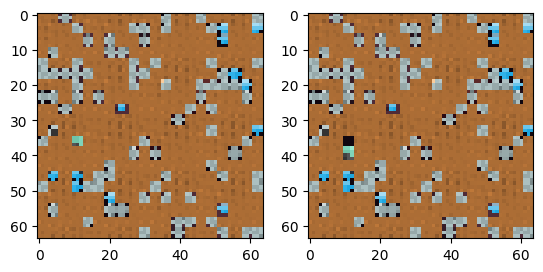

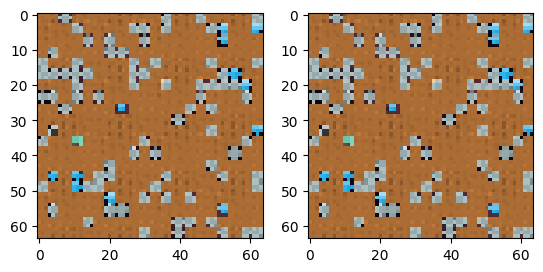

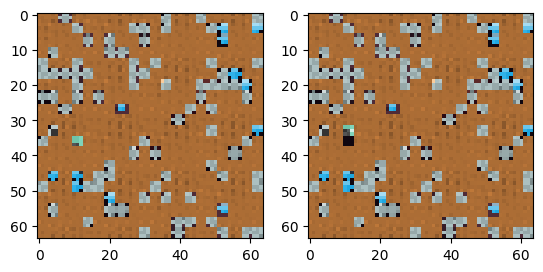

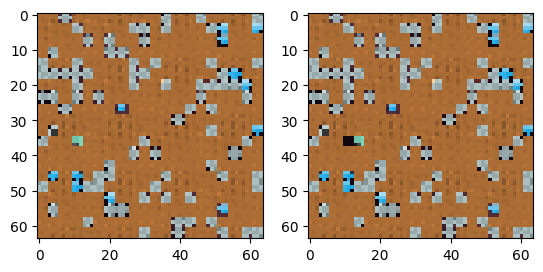

In [53]:

env = make_env(1)
obs, info = env.reset()
for action in range(env.single_action_space.n):
    env = make_env(1)
    obs, info = env.reset()
    plt.subplot(121)
    plt.imshow(obs[0, -1])
    obs, _, _, _, _ = env.step([action])
    plt.subplot(122)
    plt.imshow(obs[0, -1])
    plt.show()
    

In [ ]:
import subprocess
import re
import numpy as np

def get_mem(a):
    command = f'nvidia-smi --query-gpu=memory.{a} --format=csv'
    out = subprocess.check_output(command, shell=True)
    out = out.decode()
    out = re.findall('\d+', out)
    return np.array(out)
    
total = get_mem('total')
reserved = get_mem('reserved')
used = get_mem('used')
free = get_mem('free')
print(get_mem('total'))
print(get_mem('reserved'))
print(get_mem('used'))
print(get_mem('free'))